In [ ]:
# using https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671 as base code for this whole notebook

# All imports
# Data manipulation and NNetworks
import tensorflow as tf
import pandas as pd
import numpy as np
# File manipulation
import os
import shutil
# plotting
import matplotlib.pyplot as plt
# Time
import time

In [ ]:
import spacy
import nltk
nltk.download('stopwords')
import re
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Download dataset from repository
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84140032/84125825 [==============================] - 2s 0us/step


In [ ]:
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsupervised folder
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['pos', 'labeledBow.feat', 'neg', 'urls_pos.txt', 'unsupBow.feat', 'urls_unsup.txt', 'urls_neg.txt']


In [ ]:
# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split for training and testing.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)

test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

# Use the "test" directory for validation
valid = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
# Training set
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['Data', 'Label']
train['Data'] = train['Data'].str.decode("utf-8")
# sanity check
#print(train.head())
print(train.shape)

(20000, 2)


In [ ]:
# Test set
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['Data', 'Label']
test['Data'] = test['Data'].str.decode("utf-8")
# sanity check
#print(test.head())
print(test.shape)

(5000, 2)


In [ ]:
# Validation set
for j in valid.take(1):
  valid_feat = j[0].numpy()
  valid_lab = j[1].numpy()

valid = pd.DataFrame([valid_feat, valid_lab]).T
valid.columns = ['Data', 'Label']
valid['Data'] = valid['Data'].str.decode("utf-8")
# sanity check
#print(valid.head())
print(valid.shape)

(25000, 2)


In [ ]:
# # load back data
# df_train = pd.read_csv('normalized_train.csv')
# df_test = pd.read_csv('normalized_test.csv')
# df_valid = pd.read_csv('normalized_valid.csv')

In [ ]:
# Vectorizer imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# install transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.5 MB/s 
     |████████████████████████████████| 6.6 MB 54.9 MB/s 
     |████████████████████████████████| 120 kB 74.4 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Load BERT model + tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels = 2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:

def convert_data_to_examples(train, validation, Text, Label):
  train_InputExamples = train.apply(lambda x: InputExample(guid = None, 
                                                           text_a = x[Text],
                                                           text_b = None,
                                                           label = x[Label]), 
                                                           axis = 1)

  validation_InputExamples = validation.apply(lambda x: InputExample(guid = None, 
                                                                     text_a = x[Text], 
                                                                     text_b = None,
                                                                     label = x[Label]), 
                                                                     axis = 1)
  
  return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                         test, 
                                                                         'Data', 
                                                                         'Label')


def convert_examples_to_tf_dataset(examples, tokenizer, max_length = 128):
  features = [] 
  for e in examples:
    input_dict = tokenizer.encode_plus(e.text_a,
                                       add_special_tokens = True,
                                       max_length = max_length, 
                                       return_token_type_ids = True,
                                       return_attention_mask = True,
                                       pad_to_max_length = True, 
                                       truncation = True)
    input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                 input_dict["token_type_ids"], 
                                                 input_dict['attention_mask'])
    features.append(InputFeatures(input_ids = input_ids, 
                                  attention_mask = attention_mask, 
                                  token_type_ids = token_type_ids,
                                  label = e.label))

  def gen():
    for f in features:
      yield (
          {
                 "input_ids": f.input_ids,
                 "attention_mask": f.attention_mask,
                 "token_type_ids": f.token_type_ids,
          },
          f.label,
     )

  return tf.data.Dataset.from_generator(gen, 
                                        ({"input_ids": tf.int32, 
                                          "attention_mask": tf.int32, 
                                          "token_type_ids": tf.int32}, 
                                         tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

Data = 'Data'
Label = 'Label'

In [ ]:
# Long execution (10-15mins on colab pro)
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                         test, 
                                                                         Data, 
                                                                         Label)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(1000).batch(32).repeat(5)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), 
                                                 tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# execution of cell takes 40 mins with colab pro
BERT = model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5,
                                                          epsilon = 1e-08, 
                                                          clipnorm = 1.0),
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                     metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(train_data, 
                    epochs = 5, 
                    validation_data = validation_data, 
                    steps_per_epoch = 1000)

Epoch 1/5
1000/1000 [==============================] - 552s 529ms/step - loss: 0.2981 - accuracy: 0.8699 - val_loss: 0.3300 - val_accuracy: 0.8750
Epoch 2/5
1000/1000 [==============================] - 528s 528ms/step - loss: 0.1081 - accuracy: 0.9603 - val_loss: 0.4470 - val_accuracy: 0.8804
Epoch 3/5
1000/1000 [==============================] - 526s 526ms/step - loss: 0.0356 - accuracy: 0.9877 - val_loss: 0.5797 - val_accuracy: 0.8776
Epoch 4/5
 125/1000 [==>...........................] - ETA: 7:14 - loss: 0.0294 - accuracy: 0.9895

1000/1000 [==============================] - 90s 90ms/step - loss: 0.0294 - accuracy: 0.9895 - val_loss: 0.4780 - val_accuracy: 0.8802


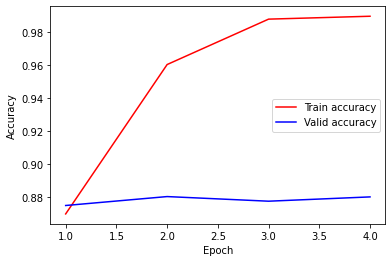

In [ ]:
# Get metrics 
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# Plot train and valid accuracy
plt.plot(epochs, acc, '-r', label = 'Train accuracy')
plt.plot(epochs, val_acc, '-b', label = 'Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 7)
plt.show()

There is a large gap between the two accuracies. This might be caused by the lack of dropout layer and/or training overfitting.

In [ ]:
# Evaluate model
print('Validation loss: %.4f' % val_loss[1])
print('Validation accuracy: %.4f' % val_acc[1])

Validation loss: 0.4470
Validation accuracy: 0.8804
